# Video: Isotonic Regression

This video introduces isotonic regression, a very flexible calibration method.


## Isotonic Regression

Isotonic regression fits a function $f(x) \approx y$ with the constraint

\begin{array}{rcl}
x_1 \leq x_2 & \Rightarrow & f(x_1) \leq f(x_2) \\
\end{array}

In other words, the output of isotonic regression must be monotonically increasings with its input.

Script:
* Isotonic regression builds a function with one input variable that fits its output.
* The isotonicity constraint is that if the input increases, the output must stay the same or increases.
* It can never go down.
* In other words, the output of an isotonic regression must increase monotonically with its input.
* It is possible to have a descending isotonic regression instead of an ascending one, but I will just focus on the ascending version.
* In practice, the $L_2$ loss function is always used to optimize an isotonic regression.
* The calibrated abalone weight from length model was made using isotonic regression.
* Let's look at that now.

## Predicting Abalone Weight from Length using Isotonic Regression


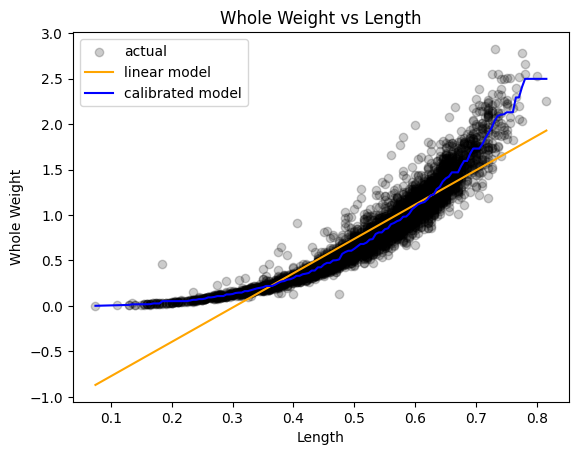

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.isotonic
import sklearn.linear_model

abalone = pd.read_csv("https://raw.githubusercontent.com/bu-cds-omds/dx602-examples/main/data/abalone.tsv", sep="\t")

feature_column = "Length"
target_column = "Whole_weight"

abalone = abalone.sort_values(by=[feature_column])

# select just the target column
abalone_target = abalone[target_column]

# just use diameter for the features
abalone_features = abalone[[feature_column]]

# build model
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(abalone_features, abalone_target)

# make predictions with this model
linear_predictions = linear_model.predict(abalone_features)

# calibration model
calibration_model = sklearn.isotonic.IsotonicRegression(out_of_bounds='clip')
calibration_model.fit(linear_predictions, abalone_target)

# calibrate the linear predictions
calibrated_predictions = calibration_model.predict(linear_predictions)

# plot actual target values vs predicted values


plt.scatter(abalone[feature_column], abalone[target_column], color="black", alpha=0.2, label="actual")
plt.plot(abalone_features, linear_predictions, color="orange", label="linear model")
plt.plot(abalone_features, calibration_model.predict(linear_model.predict(abalone_features)), color="blue", label="calibrated model")
plt.legend()
plt.xlabel(feature_column.replace('_', ' ').title())
plt.ylabel(target_column.replace('_', ' ').title())
plt.title(f"{target_column.replace('_', ' ').title()} vs {feature_column.replace('_', ' ').title()}")

None

Script:
* If you look closely at the blue curve, it's not very curvy.
* It's actually composed of several straight lines.
* Some of them horizontal, and some of them with upward slopes.
* None with downward slopes.
* At the end of the curve on the right, it is flat horizontal.

## Isotonic Regression and Conflicting Data

![The previous chart zoomed into the top right corner](https://github.com/user-attachments/assets/b6fc9199-8eac-436e-a9cc-e84cae1b1d72)

Script:
* Why are there so many flat segments
* In particular, why is there a long flat segment at the end?
* The short answer is that isotonic regression generates those flat segments whenever there is a flat or downward trend in the data.
* Real data tends to have noise, so whenever the noise is in the downward direction, there will be a brief flat segment.
* But if the real trend is upward, and there is a lot of data, those flat segments will tend to be very short.
* Why is the last flat segment longer?
* In this case, the last four data points are all down from the previous peak.
* So the isotonic regression had to pull down the predictions for that whole range to optimize the $L_2$ loss while staying monotonic.
* My interpretation of such flat segments is that they occur when the data appears to violate the monotonicity assumption, either due to noise or the assumption being wrong.
* Short flat segments do not bother me, while longer ones with a lot of data may indicate a bad assumption.
* Let's look at applying isotonic regression to data challenging that assumption.

## A Non-Monotonic Function


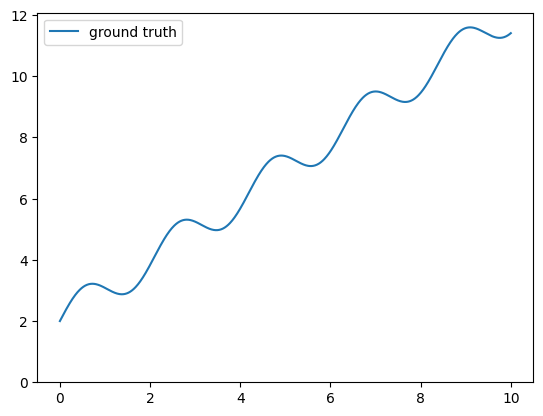

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def wavy(x):
    return x + 2 + 0.6 * np.sin(3 * x)

xs = np.linspace(0, 10, num=1000)
plt.plot(xs, wavy(xs), label="ground truth")

plt.gca().set_ylim(0)

plt.legend()

None

Script:
* Here's another version of the wavy line function.
* It is still just a linear function plus a sine function, but I increased the sine function's coefficient to exagerate the up and down pattern.
* Let's see what isotonic regression can do with this.

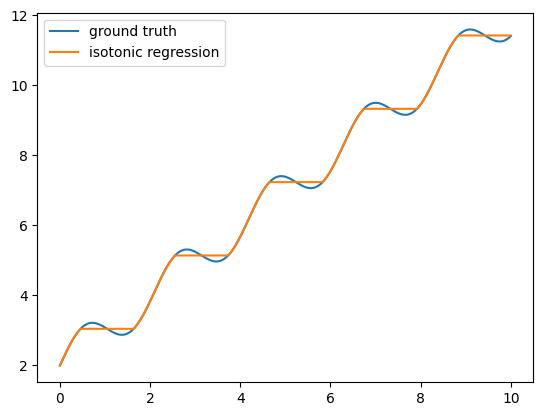

In [ ]:
import sklearn.isotonic

model = sklearn.isotonic.IsotonicRegression()
model.fit(xs, wavy(xs))

plt.plot(xs, wavy(xs), label="ground truth")
plt.plot(xs, model.predict(xs), label="isotonic regression")

plt.legend()

None

Script:
* Scikit-learn treats isotonic regression as just another modeling type.
* It follows the same pattern of fitting and predicting.
* So it takes very little code to produce this isotonic version of the wavy line.
* One minor difference from the other modeling classes such as linear regression is that it only requires a one-dimensional input, so you do not need to reshape it to have one column.
* Looking at the isotonic regression output, every time the wavy line peaks and dips briefly, there is a flat segment.
* In these cases, it looks pretty centered on the down segment with some errors on both sides.
* You could imagine moving the flat segment to the left and having more errors on the upside, or moving it to the right and having more errors on the downside.
* Those tweaks would put all the errors on one side, and in particular, increase the largest residuals, so the $L_2$ loss function optimizes away from those in favor of smaller more balanced errors.


## Criticisms of Isotonic Regression

* Isotonic has too much freedom and overfits.
* Flat segments and end handling are unsightly.

IMAGE repeat previous chart but smaller

Script:
* The main criticism that I have heard about isotonic regression is that it has too much freedom to fit curves, and overfits.
* It certainly has a lot of freedom, and can fit any truely monotonic curve.
* But the catch is that it needs the data to fit that pattern, and that is increasingly less likely to happen by chance as you get more data.
* But yes, it can overfit a lot with just a little data, similar to other methods with just a little data.
* But it overfits in certain ways.
* I think a more nuanced criticism has to do with the flat segments.
* I don't find them particularly unsightly; I actually like that they call out ranges where monotonicity did not beat out noise.
* But if you zoom in on the regression curve, and see lots of little flat segments, the fine-grained dynamics are wrong.
* The overall shape of the curve may be fine, but if you look closely, it looks like stairs.
* Flat then steep then flat then steep.
* So this kind of regression is not so good if you want to understand the curve by looking at the slopes.

## Availability of Isotonic Regression

* In theory:
  * Can be used for many variables at once.
  * Various loss functions, mostly $L_p$ for various $p$.
  * Handling multiple variables is substantially slower.
* In practice:
  * Very fast for one input variable. `sklearn.isotonic.IsotonicRegression`
  * Exact implementations for multiple variables are rare.
  * Approximate implementations via gradient boosted trees.
    * `sklearn` and `xgboost` have the monotonicity constraints.

Script:
* In practice, most direct use of isotonic regression has focused on the one variable case.
* The one variable case is fast, and convenient for calibration.
* In a few cases, I've seen isotonic regression be enough of a fix to make a model economically viable on its own.
* There are fancier versions floating around that handle multiple input variables and different loss functions, but with one exception, they have not gotten traction since they tend to be more expensive too.
* The one exception is that a few implementations of gradient boosted tree models support monotonicity constraints.
* Both scikit-learn and the other open source package xgboost can build models with these constraints, and get a pretty good approximation of isotonic regression with multiple variables.
* The catch is that they are not exact solutions, but they seem pretty good in practice.